In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.contrib import rnn
from tensorflow.python.ops import variable_scope
from tensorflow.python.framework import dtypes
import copy,os
import pickle
from datetime import timedelta

plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

import seaborn as sns
sns.set()

## Experiment part 1: End to end V.S. two-stage model (MQRNN)

In [3]:
df_sales = pd.read_csv('../data/1320/rdc_sales_1320_replenishment_V1_filled_pp.csv')
df_sl = df_sales.set_index('row')
df_sl.rename(columns=lambda x: (dt.datetime(2016,1,1) + dt.timedelta(days=int(x)-730)).date(), inplace=True)
df_sl['SKU'], df_sl['DC'] = df_sl.index.str.split('#', 1).str

In [4]:
START_DAY = dt.datetime(2018,7,27)

#Benchmark2 qunatile prediction: quantiles = [0.1, 0.25, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
with open('pred_E2E_SF_RNN.pkl', 'rb') as fp: 
    bc2 = pickle.load(fp)

#Item_sku_id, sku_id, create_tm, complete_dt, vlt_actual, E2E_MLP_pred, E2E_NN_SF_mean_pred, E2E_NN_vlt_pred 
df_orders = pd.read_csv('pred_v5.csv')

#Add item SKU/DC, create date and arrive date reference to 07/30
df_orders['SKU'], df_orders['DC'] = df_orders['item_sku_id'].str.split('#', 1).str
df_orders['create_tm_index'] = [int((pd.to_datetime(df_orders['create_tm'][i]).date()-START_DAY.date())/dt.timedelta (days=1)) 
                    for i in range(len(df_orders))]
df_orders['complete_tm_index'] = [int((pd.to_datetime(df_orders['complete_dt'][i]).date()-START_DAY.date())/dt.timedelta (days=1)) 
                    for i in range(len(df_orders))]
df_orders['next_complete_tm_index'] = [int((pd.to_datetime(df_orders['next_complete_dt'][i]).date()-START_DAY.date())/dt.timedelta (days=1)) 
                    for i in range(len(df_orders))]
df_orders.head()

,item_sku_id,sku_id,create_tm,complete_dt,vlt_actual,E2E_MLP_pred,E2E_RNN_pred,E2E_NN_SF_mean_pred,E2E_NN_vlt_pred,review_period,next_complete_dt,SKU,DC,create_tm_index,complete_tm_index,next_complete_tm_index
0,258214#3,258214,7/30/18 4:50,8/4/18 16:34,5.488264,1485.4271,2268.90280,557.55210,6.363373,1.417975,8/4/18 16:27,258214,3,3,8,8
1,258214#3,258214,7/31/18 14:52,8/4/18 16:27,4.066100,2276.1375,2564.64800,638.37350,6.138837,7.062083,8/14/18 15:46,258214,3,4,8,18
2,258214#3,258214,8/7/18 16:22,8/14/18 15:46,6.975035,1735.7422,2101.61990,728.61250,5.566259,5.543704,8/18/18 14:39,258214,3,11,18,22
3,258214#3,258214,8/13/18 5:25,8/18/18 14:39,5.384803,2011.5070,2473.88350,711.59010,6.034840,6.987188,8/25/18 14:41,258214,3,17,22,29
4,258214#4,258214,7/30/18 4:50,8/8/18 23:09,9.763206,500.8687,334.82117,118.85773,9.574233,7.017778,8/15/18 23:17,258214,4,3,12,19


In [5]:
def num_neg_element(data_list):
    counter = 0
    for i in data_list:
        if i < 0:
            counter+=1
    return counter 

def countOccurrences(arr, x):
    res = 0
    for i in range(len(arr)):
        if x == arr[i]:
            res += 1
    return res
            
def seqtest(sku, dc, inv0, demand, actions, end_of_horizon, 
                                   arrive_time, order_time, VLT_pred, rp, OPTION=0):
    inv = inv0
    h = 1
    b = 9
    history_inv = []
    order_list = []
    h_cost_list = []
    b_cost_list = []
    cost_list = []
    #print('Initial Inventory:', inv0)
    
    for t in range(end_of_horizon):        
        if t in order_time:
            occurance = countOccurrences(order_time, t)
            count = occurance
            while(occurance>0):
                i = order_time.index(t)+ count - occurance
                review_period = rp[i]
                '''---------------------- OPTION 0: End2end MLP ---------------------------------------'''
                '''---------------------- OPTION 1: End2End RNN-------------------------------'''
                '''---------------------- OPTION 2: Benchmark1 ---------------------------------------'''
                '''---------------------- OPTION 3: Benchmark2 ------------------------------------'''
                if(OPTION==0): #End2end MLP
                    order = np.max([actions[i]-inv, 0])
                elif(OPTION==1): #End2End RNN
                    order = np.max([actions[i]-inv, 0])
                    #print('Action:', actions[i], 'Current inv:', inv, 'order:', order)
                elif(OPTION==2): #Benchmark1
                    days = int(review_period+VLT_pred[i])
                    future_sales = actions[i]
                    total_sale = np.mean(future_sales)*days
                    order = np.max([total_sale-inv, 0])
                    #days = int(review_period+VLT_pred[i])
                    #total_sale = actions[i]*days
                elif(OPTION==3): #Benchmark2
                    days = int(review_period+VLT_pred[i])
                    future_sales = actions[i]
                    total_sale = np.sum(future_sales[0:days])
                    order = np.max([total_sale-inv, 0])
                else: 
                    order = 0
                
                order_list.append(order)
                occurance = occurance-1
        
        if t in arrive_time:
            occurance = countOccurrences(arrive_time, t)
            while(occurance>0):
                i = arrive_time.index(t)+occurance-1
                #print('receiving ',i , 'th order at time', t, 'Order qtty:', order_list[i])
                inv = inv + order_list[i]
                occurance = occurance-1
            #print('placing ', i, 'th order at time', t, 'Order qtty:', order, 'order list:', order_list)

        inv = inv - demand[t]
     
        h_cost = h*np.maximum(0, inv)
        b_cost = b*np.maximum(0, -inv)
        h_cost_list.append(h_cost)
        b_cost_list.append(b_cost)
        cost_list.append(h_cost+b_cost)
        
        history_inv.append(int(inv))
    
    return history_inv, sum(cost_list), sum(b_cost_list), sum(h_cost_list)

No. 0 sample SKU: 258214 DC: 3
No. 100 sample SKU: 851968 DC: 6
No. 200 sample SKU: 1078117 DC: 5
No. 300 sample SKU: 1225982 DC: 3
No. 400 sample SKU: 1291958 DC: 4
No. 500 sample SKU: 1724627 DC: 10
No. 600 sample SKU: 1978185 DC: 5
No. 700 sample SKU: 2649245 DC: 3
No. 800 sample SKU: 3236240 DC: 772
No. 900 sample SKU: 3763759 DC: 4
No. 1000 sample SKU: 4117328 DC: 3
No. 1100 sample SKU: 4462757 DC: 3
No. 1200 sample SKU: 4695677 DC: 6
No. 1300 sample SKU: 4983910 DC: 9
No. 1400 sample SKU: 5396064 DC: 9
No. 1500 sample SKU: 5822221 DC: 3
No. 1600 sample SKU: 6679182 DC: 3
-------------------------------- Cost Comparison ---------------------------------------------
E2E MLP: Total cost: 208.29 Backorder cost: 0.0 Holding cost: 208.29
E2E RNN: Total cost: 494.3303999999999 Backorder cost: 0.0 Holding cost: 494.3303999999999
Benchmark1: Total cost: 699.7065505981445 Backorder cost: 0.0 Holding cost: 699.7065505981445
Benchmark1: Total cost: 675.9658203125 Backorder cost: 0.0 Holding 

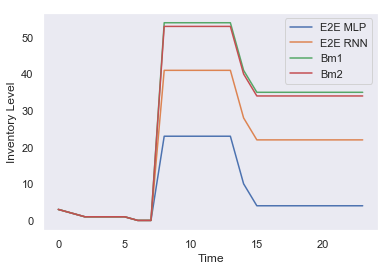

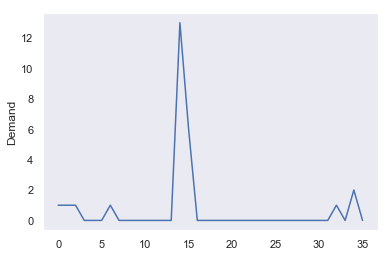

In [7]:
numberOfRows = 1667
#numberOfRows = len(df_orders)

df_cost = pd.DataFrame(index=np.arange(0, numberOfRows), columns=['SKU', 'DC', 'E2E_MLP', 'E2E_RNN', 'Bm1', 'Bm2', 'Ave_sales', 'Sales_std'])
df_holding = pd.DataFrame(index=np.arange(0, numberOfRows), columns=['SKU', 'DC', 'E2E_MLP', 'E2E_RNN', 'Bm1', 'Bm2', 'Ave_sales', 'Sales_std'])
df_back = pd.DataFrame(index=np.arange(0, numberOfRows), columns=['SKU', 'DC', 'E2E_MLP', 'E2E_RNN', 'Bm1', 'Bm2', 'Ave_sales', 'Sales_std'])
df_stockout = pd.DataFrame(index=np.arange(0, numberOfRows), columns=['SKU', 'DC', 'E2E_MLP', 'E2E_RNN', 'Bm1', 'Bm2', 'Ave_sales', 'Sales_std'])
df_turnover = pd.DataFrame(index=np.arange(0, numberOfRows), columns=['SKU', 'DC', 'E2E_MLP', 'E2E_RNN', 'Bm1', 'Bm2', 'Ave_sales', 'Sales_std'])

simu_start_date = (dt.datetime(2018,7,27) - dt.datetime(2016,1,1)).days
end_of_horizon = 30 #07/26-08/20

t = 0
for i in range(numberOfRows):
    if(t>len(df_orders)-1):
        break
    '''Get the current SKU id and DC id'''
    sku = df_orders.loc[t]['SKU']
    dc = df_orders.loc[t]['DC']
    #sku =  '258214'
    #dc = '4'
    if(i%100==0):
        print('No.', i, 'sample', 'SKU:', sku, 'DC:', dc)
    
    '''Initialize the cost dataframe'''
    df_cost.loc[i]['SKU'] = df_holding.loc[i]['SKU'] = df_back.loc[i]['SKU'] = df_stockout.loc[i]['SKU'] = df_turnover.loc[i]['SKU'] = sku
    df_cost.loc[i]['DC'] = df_holding.loc[i]['DC'] = df_back.loc[i]['DC'] = df_stockout.loc[i]['DC'] = df_turnover.loc[i]['DC'] = dc
    
    '''Order create time, arrive time and predicted VLT'''
    df = df_orders[(df_orders.SKU == sku) & (df_orders.DC == dc)]
    index = df.index
    order_time = df['create_tm_index'].tolist()
    arrive_time = df['complete_tm_index'].tolist()
    next_arrive_time = df['next_complete_tm_index'].tolist()
    end_of_horizon = max(next_arrive_time)
    VLT_pred = df['E2E_NN_vlt_pred'].tolist()
    rp = df['review_period'].tolist()
    
    '''Get the corresponding demand within the test time frame: 2018/07/30-2018/08/31'''
    demand = df_sl[(df_sl.SKU == sku) & (df_sl.DC == dc)].values.tolist()[0]
    demand = demand[simu_start_date:-2]
    demand = np.array([int(i) for i in demand])
    
    '''Get the actions for the End2end methods, benchmark1 and benchmark2'''
    End2end_mlp_list = df['E2E_MLP_pred'].tolist()
    End2end_rnn_list = df['E2E_RNN_pred'].tolist()
    bm1_list = df['E2E_NN_SF_mean_pred'].tolist()
    bm2_list = np.array([bc2[i, :, 6] for i in index])
    
    if(len(demand)==0): 
        '''If cann't find the demand data of this SKU, DC, go to the next test index'''
        t = t+1
    else:
        #inv0  = np.array(df['initial_stock'])[0]
        inv0 = np.sum(demand[0:min(arrive_time)]) 
        
        h = 1
        b = 9

        sales_mean = np.mean(demand)
        sales_std = np.std(demand)
        
        '''----------------------------------- OPTION 0: E2E_MLP ----------------------------'''
        inv1, c1, b1, h1 = seqtest(sku, dc, inv0, demand, End2end_mlp_list, end_of_horizon, 
                                   arrive_time, order_time, VLT_pred, rp, OPTION=0)
        
        df_cost.loc[i]['E2E_MLP'] = c1
        df_holding.loc[i]['E2E_MLP'] = h1
        df_back.loc[i]['E2E_MLP'] = b1
        df_stockout.loc[i]['E2E_MLP'] = num_neg_element(inv1)/len(inv1)
        df_turnover.loc[i]['E2E_MLP'] = np.mean(inv1)/sales_mean
        
        '''----------------------------------- OPTION 1: E2E_RNN ----------------------------'''
        inv2, c2, b2, h2 = seqtest(sku, dc, inv0, demand, End2end_rnn_list, end_of_horizon, 
                                   arrive_time, order_time, VLT_pred, rp, OPTION=1)
        df_cost.loc[i]['E2E_RNN'] = c2
        df_holding.loc[i]['E2E_RNN'] = h2
        df_back.loc[i]['E2E_RNN'] = b2
        df_stockout.loc[i]['E2E_RNN'] = num_neg_element(inv2)/len(inv2)
        df_turnover.loc[i]['E2E_RNN'] = np.mean(inv2)/sales_mean
        
        '''----------------------------------- OPTION 2: Bm1 ----------------------------'''
        inv3, c3, b3, h3 = seqtest(sku, dc, inv0, demand, bm2_list, end_of_horizon, 
                                   arrive_time, order_time, VLT_pred, rp, OPTION=2)
        df_cost.loc[i]['Bm1'] = c3
        df_holding.loc[i]['Bm1'] = h3
        df_back.loc[i]['Bm1'] = b3
        df_stockout.loc[i]['Bm1'] = num_neg_element(inv3)/len(inv3)
        df_turnover.loc[i]['Bm1'] = np.mean(inv3)/sales_mean
    
        '''----------------------------------- OPTION 3: Bm2 ----------------------------'''
        inv4, c4, b4, h4 = seqtest(sku, dc, inv0, demand, bm2_list, end_of_horizon, 
                                   arrive_time, order_time, VLT_pred, rp, OPTION=3)
        df_cost.loc[i]['Bm2'] = c4
        df_holding.loc[i]['Bm2'] = h4
        df_back.loc[i]['Bm2'] = b4
        df_stockout.loc[i]['Bm2'] = num_neg_element(inv4)/len(inv4)
        df_turnover.loc[i]['Bm2'] = np.mean(inv4)/sales_mean    
        
        df_cost.loc[i]['Ave_sales'] = sales_mean
        df_cost.loc[i]['Sales_std'] = sales_std
        df_holding.loc[i]['Ave_sales'] = sales_mean
        df_holding.loc[i]['Sales_std'] = sales_std
        df_back.loc[i]['Ave_sales'] = sales_mean
        df_back.loc[i]['Sales_std'] = sales_std
        df_stockout.loc[i]['Ave_sales'] = sales_mean
        df_stockout.loc[i]['Sales_std'] = sales_std
        df_turnover.loc[i]['Ave_sales'] = sales_mean
        df_turnover.loc[i]['Sales_std'] = sales_std
        
        t = t+len(df)

plt.figure()
plt.plot(figsize=(20,10))
plt.plot(inv1, label = 'E2E MLP')
plt.plot(inv2, label = 'E2E RNN')
plt.plot(inv3, label = 'Bm1')
plt.plot(inv4, label = 'Bm2')
plt.ylabel('Inventory Level')
plt.xlabel('Time')
plt.grid()
plt.legend()


print('-------------------------------- Cost Comparison ---------------------------------------------')
print('E2E MLP:', 'Total cost:', round(c1,2), 'Backorder cost:', round(b1,2), 'Holding cost:', round(h1,2))
print('E2E RNN:', 'Total cost:', c2, 'Backorder cost:', b2, 'Holding cost:', h2)
print('Benchmark1:', 'Total cost:', c3, 'Backorder cost:', b3, 'Holding cost:', h3)
print('Benchmark1:', 'Total cost:', c4, 'Backorder cost:', b4, 'Holding cost:', h4)

plt.figure()
plt.plot(demand)
plt.ylabel('Demand')
plt.grid()

In [8]:
df_cost = df_cost.dropna()
df_holding = df_holding.dropna()
df_back = df_back.dropna()
df_stockout = df_stockout.dropna()
df_turnover = df_turnover.dropna()

In [34]:
df_cost = df_cost.iloc[2:].astype('float')
df_holding = df_holding.iloc[2:].astype('float')
df_back = df_back.iloc[2:].astype('float')
df_stockout = df_stockout.iloc[2:].astype('float')
df_turnover = df_turnover.iloc[2:].astype('float')

In [9]:
len(df_cost)

1667

In [11]:
str_list2 = ['E2E_MLP', 'E2E_RNN', 'Bm1','Bm2']

In [17]:
df_com = pd.DataFrame({'Total cost': df_cost[str_list2].mean(),
             'Holding cost': df_holding[str_list2].mean(),
             'Stockout cost': df_back[str_list2].mean(),
             'Stockout rate': df_stockout[str_list2].mean(),
             'Turnover rate': df_turnover[str_list2].mean(),
             }).T
df_com

,E2E_MLP,E2E_RNN,Bm1,Bm2
Total cost,5233.381262,5402.845778,6836.601228,6696.364697
Holding cost,4053.275998,4015.011439,6081.120418,5904.984906
Stockout cost,1180.105264,1387.834340,755.480810,791.379791
Stockout rate,0.046936,0.050541,0.007296,0.008455
Turnover rate,9.756528,11.612870,19.401465,18.812502


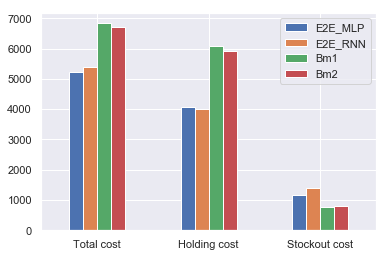

In [20]:
df_com.iloc[0:3,:].plot.bar(rot=0)
plt.savefig('../figures/eps/exp1.eps', dpi=200)

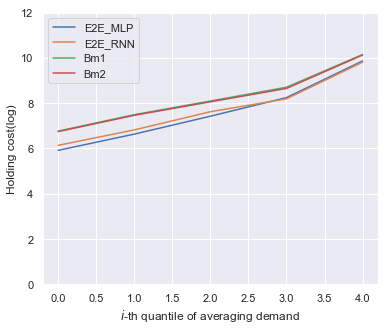

In [42]:
sl_qtl = df_holding.iloc[:,2:].sort_values('Ave_sales').groupby(df_cost.index//360).mean()
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(np.log(sl_qtl.iloc[:,:-2].astype(float)).replace(-np.inf, 0));
ax.legend(sl_qtl.columns[:-2], loc=0)
ax.set_xlabel('$i$-th quantile of averaging demand');
ax.set_ylabel('Holding cost(log)');
ax.set_ylim((0,12));
# plt.savefig('../figures/eps/qtl2.eps', dpi=200)